# This script identifies LG analogues in the halo catalogue and extracts the merger tree data from the tree file, in preparation for plotting.

### Running this script requires the Mini-Uchuu z=0 halo catalog and merger tree files, which are available at skiesanduniverses.org.

Note that some steps take a lot of time (mostly due to reading files from disk). If you don't want to rerun them each time, skip those cells. This script is designed to save intermediate results to disk and read them from disk.

### Define path for local modules

This will depend on your particular environment and will not be necessary if you have all packages that are imported below in your standard python path.

In [134]:
import sys
print(sys.path)

sys.path.append('C:/Users/equel/AppData/Local/Packages/PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0/LocalCache/local-packages/Python313/site-packages')

print("now:", sys.path)


['C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.13_3.13.752.0_x64__qbz5n2kfra8p0\\python313.zip', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.13_3.13.752.0_x64__qbz5n2kfra8p0\\DLLs', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.13_3.13.752.0_x64__qbz5n2kfra8p0\\Lib', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.13_3.13.752.0_x64__qbz5n2kfra8p0', '', 'C:\\Users\\equel\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python313\\site-packages', 'C:\\Users\\equel\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python313\\site-packages\\win32', 'C:\\Users\\equel\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python313\\site-packages\\win32\\lib', 'C:\\Users\\equel\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.13_qbz5

### Imports

In [135]:
import numpy as np
import h5py

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import scipy.stats as stats
from scipy.stats import linregress
from scipy.stats import gaussian_kde
from scipy.stats import multivariate_normal
from scipy.stats import norm


from scipy.signal import savgol_filter   


import math

from scipy import optimize
from scipy.optimize import fsolve
from scipy import spatial

import heapq

import timeit
import glob
from tqdm import tqdm

import os
import pickle
import psutil

from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import z_at_value

from itertools import zip_longest

print ("loaded modules")

loaded modules


### Parameters

In [136]:
# File for the z=0 LG data.
LG_data_file = 'new_MiniUchu_data_m200_pos_gravity_IDs_rgrav=5.npz'  # files selected by m200, includes the gravity calculation

LG_tree_file = 'new_MiniUchu_treedata_set.npz'

cosmo = FlatLambdaCDM(H0=67.74, Om0=0.3, Tcmb0=2.725)

hubble = .6774

G = 4300700 # for M in units of 10^12
max_residual = 1e-4 # for the TA solution
bounds = [(1e-2, 2*np.pi)] # bounds on eta for slsqp solver

boxSize = 2000. / hubble * 1000. 

m_MW_min = 0.7e12  # minimum mass for the MW haloes at z=0
m_MW_max = 1.5e12 # maximum mass for the MW haloes at z=0
m_M31_min = 1.0e12 # minimum mass for the M31 haloes at z=0
m_M31_max = 2.0e12 # maximum mass for the M31 haloes at z=0


snapshots = np.array([50,45,40,30,20,15,12])
particle_index = np.arange(0,len(snapshots))   # for indexing the particle data
tree_index = 50 - snapshots                    # for indexing the tree data

fine_index = np.arange(0,max(tree_index)+1)

print ("tree indices:", tree_index, "particle indices:", particle_index)
print ("fine index:", fine_index)

# ages to display
ages = np.array([13, 10, 8, 6, 5, 4, 3, 2, 1])*u.Gyr
ageticks = [1 / (1 + z_at_value(cosmo.age, age)) for age in ages]

# redshifts to display 
label_redshifts = np.array([4,3,2,1,0.5,0.2,0])
label_redshifts_str = ["4","3","2","1","0.5","0.2","0"]
label_scales = 1 / (label_redshifts + 1)

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"


m_min_gravity = 0.2e12 # consider perturbers above 2 x 10^11

N_volumes = 1 # For Mini-Uchuu, there is only one file

basePath = 'D:/Uchuu/'

tree indices: [ 0  5 10 20 30 35 38] particle indices: [0 1 2 3 4 5 6]
fine index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]


### Custom Functions

In [137]:
# We solve the eta equation, and then calculate a, M_TA and e.

# solve to obtain eta from t, r, vr, vt
def EtaEquation(eta, *data):
    r, vr, vt, t = data

    epsilon = 1e-10

    c = vt**2 / vr**2
    eqn = t * vr / r - np.sin(eta) * ( eta * (c * np.sin(eta)*np.sin(eta) + 1)**.5 - np.sin(eta)) / ((np.cos(eta) - (c * np.sin(eta) * np.sin(eta) + 1)**.5)**2+epsilon)
    
    eqn = np.abs(eqn)
    
    return eqn


# The full TA equations, only used to check results
def TAequations(variables, *data):
    
    r, vr, vt, t = data[0]
    G = 4300700 # for M in units of 10^12
    
    a, e, eta, M = variables
    
    a = a * 1000 # to have a in Mpc
    
    eqn_1 = (a * (1. - e * np.cos(eta) ) - r) 
    eqn_2 = ( (a**3 / (G * M) )**.5 * (eta - e * np.sin(eta) ) - t ) 
    eqn_3 = ((G * M) / a)**.5 * e * np.sin(eta)  / (1. - e * np.cos (eta) + 1.e-12) - vr
    eqn_4 = ((G * M) / a)**.5 * (1. - e**2)**.5 / (1. - e * np.cos(eta) + 1.e-12) - vt
    return [eqn_1, eqn_2, eqn_3, eqn_4]


def evalTA(p, *data): # evaluate the general TA given the parameters and the data
    return abs(sum(np.array(TAequations(p, data))**2))




### Read the Uchuu scale factors

In [138]:
'''f = open('Uchuu_redshift_scalefactors.txt', 'r')

lines = f.readlines()
scale = []
                  
for line in lines:
    columns = line.split()
    scale.append(float(columns[2]))

scale = np.flip(scale)
print ("scalefactors:", scale)'''

'f = open(\'Uchuu_redshift_scalefactors.txt\', \'r\')\n\nlines = f.readlines()\nscale = []\n\nfor line in lines:\n    columns = line.split()\n    scale.append(float(columns[2]))\n\nscale = np.flip(scale)\nprint ("scalefactors:", scale)'

In [139]:
scale = [0.999887, 0.977848, 0.956412, 0.914941, 0.87523, 0.837539, 0.801034, 0.766456,
 0.733135, 0.701575, 0.671151, 0.642035, 0.614153, 0.587537, 0.562099, 0.537713,
 0.514356, 0.49213, 0.470773, 0.450389, 0.430727, 0.412155, 0.394333, 0.377182,
 0.360886, 0.34528, 0.330255, 0.315864, 0.30214, 0.289175, 0.276536, 0.264684,
 0.253086, 0.242223, 0.231799, 0.216898, 0.202878, 0.189856, 0.177649, 0.162519,
 0.148772, 0.136158, 0.124496, 0.113967, 0.104325, 0.095413, 0.087363, 0.079949,
 0.073131, 0.066964]

scale = np.array(scale)

### Read the halo catalogue.
#### This is done in addition to the tree file, as it contains the tidal information. 

In [140]:
files = glob.glob(basePath+'MiniUchuu_halolist_z0p00.h5')

files = np.sort(files)

print ("files:", files)

for i in range(N_volumes):

    print ("i:", i)
    hf = h5py.File(files[i], 'r')

    Datasetnames=hf.keys()                                                                                                                                              
    print (Datasetnames)                                                                                                                                                

    x = np.array( hf['x']) / hubble * 1000. # get coordinates in kpc
    y = np.array( hf['y']) / hubble * 1000.
    z = np.array( hf['z']) / hubble * 1000.

    m200 = np.array( hf['M200c']) / hubble # get physical masses

    print ("i:", i, "N:", len(x) )

    vx = np.array( hf['vx']) # velocities are physical 
    vy = np.array( hf['vy'])
    vz = np.array( hf['vz'])

    pos = np.array([x, y, z])
    vel = np.array([vx, vy, vz])

    pid = np.array(hf['pid'])
    ID = np.array(hf['id'])

    TidalID = np.array(hf['Tidal_ID'])

    hf.close()

    vel = vel.T
    pos = pos.T
    
print ("done reading halo catalogue")

files: ['D:/Uchuu/MiniUchuu_halolist_z0p00.h5']
i: 0
<KeysViewHDF5 ['A_x', 'A_x_500c', 'A_y', 'A_y_500c', 'A_z', 'A_z_500c', 'Acc_Rate_100Myr', 'Acc_Rate_1_Tdyn', 'Acc_Rate_2_Tdyn', 'Acc_Rate_Inst', 'Acc_Rate_Mpeak', 'Acc_Scale', 'Breadth_first_ID', 'Depth_first_ID', 'First_Acc_Mvir', 'First_Acc_Scale', 'First_Acc_Vmax', 'Future_merger_MMP_ID', 'Halfmass_Radius', 'Halfmass_Scale', 'Jx', 'Jy', 'Jz', 'Last_mainleaf_depthfirst_ID', 'Last_progenitor_depthfirst_ID', 'Log_Vmax_Vmax_max_Tdyn_Tmpeak_', 'M200b', 'M200c', 'M2500c', 'M500c', 'M_pe_Behroozi', 'M_pe_Diemer', 'Macc', 'Mpeak', 'Mpeak_Scale', 'Mvir', 'Mvir_all', 'Next_coprogenitor_depthfirst_ID', 'Orig_halo_ID', 'Rs_Klypin', 'Rvir', 'Snap_num', 'Spin', 'Spin_Bullock', 'T_U', 'Tidal_Force', 'Tidal_Force_Tdyn', 'Tidal_ID', 'Time_to_future_merger', 'Tree_root_ID', 'Vacc', 'Vmax_Mpeak', 'Voff', 'Vpeak', 'Xoff', 'b_to_a', 'b_to_a_500c', 'c_to_a', 'c_to_a_500c', 'desc_id', 'desc_pid', 'desc_scale', 'id', 'mmp', 'num_prog', 'phantom', 'pid',

### Find pairs in the halo catalogue

In [141]:
print("ID > 0", len(TidalID[ID > 0]))
print("TidalID > 0", len(TidalID[TidalID > 0]))
print("TidalID < 0", len(TidalID[TidalID < 0]))


# Select subhalo samples

totNum = len(m200)

print("Total number of halos:", totNum)

# Select MW halo
selectIndex_MW = np.full(totNum, False)
selectIndex_MW[m200 > m_MW_min] = True
selectIndex_MW[m200 > m_MW_max] = False

selectNum_MW = len(m200[selectIndex_MW])

print('Number of selected MW halos:', selectNum_MW)

print('Minimum mass:', min(m200[selectIndex_MW]) / 1.e12, ' x 10^12' )
print('Maximum mass:', max(m200[selectIndex_MW]) / 1.e12, ' x 10^12' )

# Select M31 halo
selectIndex_M31 = np.full(totNum, False)
selectIndex_M31[m200 > m_M31_min] = True
selectIndex_M31[m200 > m_M31_max] = False

selectNum = len(m200[selectIndex_M31])

print('Number of selected M31 halos:', selectNum)

print('Minimum mass:', min(m200[selectIndex_M31]) / 1.e12, ' x 10^12' )
print('Maximum mass:', max(m200[selectIndex_M31]) / 1.e12, ' x 10^12' )


M_MW = []
M_M31 = []

ID_MW = []
ID_M31 = []

M_MW = np.array(list(m200[selectIndex_MW]))
M_M31 = np.array(list(m200[selectIndex_M31]))

ID_MW = np.array(list(ID[selectIndex_MW]))
ID_M31 = np.array(list(ID[selectIndex_M31]))


ID > 0 33585418
TidalID > 0 33574429
TidalID < 0 10989
Total number of halos: 33585418
Number of selected MW halos: 262392
Minimum mass: 0.7004723944493653  x 10^12
Maximum mass: 1.4998523767345733  x 10^12
Number of selected M31 halos: 177798
Minimum mass: 1.000265721877768  x 10^12
Maximum mass: 2.0  x 10^12


### Save z=0 data to file

In [142]:
print ("file:", LG_data_file)

file: new_MiniUchu_data_m200_pos_gravity_IDs_rgrav=5.npz


In [143]:
np.savez(LG_data_file, allow_pickle = True, M_MW = M_MW, M_M31 = M_M31)

print ('done writing file')

done writing file


### Read the LG data file back

In [144]:
data = np.load(LG_data_file)  # files selected by m200, includes the gravity calculation

print (list(data.keys()))

M_MW = data['M_MW']
M_M31 = data['M_M31']

print ('done reading LG file')

['M_MW', 'M_M31']
done reading LG file


### Load the tree files.
#### In Mini-Uchuu, this is ascii, spread over 512 files.
#### On Puhti's file system, this takes around 90 minutes.

In [12]:
treefile_root = "D:/Uchuu/MiniUchuu_"

treefiles = []

mass_threshold = min(m_MW_min,m_M31_min)

for i in range(1):
    for j in range (6):
        for k in range (8):
            treefiles.append(treefile_root+str(i)+"_"+str(j)+"_"+str(k)+".trees" )
            
NFiles = len(treefiles)
            
NTrees = 0

print ("reading 512 tree files. This will take a while.")

for i, file in enumerate (tqdm(treefiles)):
    
    f = open(file, 'r')

    lines = f.readlines()[49:] # we skip the header

    NewTree = True

    for line in lines:

        columns = line.split()
    
        if len(columns) < 3  : # start of a new tree. Add haloes as long as the scale factor decreases along the main progenitor branch.
            
            NewTree = True
        
            if NTrees == 0:
                # First Tree. Initialising lists.
                ID_tree = []
                mass_tree = []
                x_tree = []
                y_tree = []
                z_tree = []
                vx_tree = []
                vy_tree = []
                vz_tree = []
                snapnum_tree = []

            else:  # This is not the first tree. It's time to add the last tree to the list.

                # To save memory, we only append if the z=0 mass is above the threshold for MW / M31 analogues.
                if mass[0] > mass_threshold * hubble:
                
                    ID = np.array(ID)
                    mass = np.array(mass)
                    x = np.array(x)
                    y = np.array(y)
                    z = np.array(z)
                    vx = np.array(vx)
                    vy = np.array(vy)
                    vz = np.array(vz)
                    snapnum = np.array(snapnum)

                    ID_tree.append(ID)
                    mass_tree.append(mass)
                    x_tree.append(x)
                    y_tree.append(y)
                    z_tree.append(z)
                    vx_tree.append(vx)
                    vy_tree.append(vy)
                    vz_tree.append(vz)
                    snapnum_tree.append(snapnum)

            NTrees = NTrees + 1

        else:

            if NewTree == False:
                if int(columns[34]) == LastProgID: # this halo is from the main progenitor branch

                # print ("snap:", snap)
                    ID.append(int(columns[1]))
                    mass.append(float(columns[10]))
                    x.append(float(columns[17]))
                    y.append(float(columns[18]))
                    z.append(float(columns[19]))
                    vx.append(float(columns[20]))
                    vy.append(float(columns[21]))
                    vz.append(float(columns[22]))
                    snapnum.append(float(columns[31]))

            if NewTree == True:

                LastProgID = int(columns[34])
                # Initialise arrays:
                ID = [int(columns[1])]
                mass = [float(columns[10])]
                x = [float(columns[17])]
                y = [float(columns[18])]
                z = [float(columns[19])]
                vx = [float(columns[20])]
                vy = [float(columns[21])]
                vz = [float(columns[22])]
                snapnum = [float(columns[31])]

                NewTree = False

    f.close
    
print ("all done")


reading 512 tree files. This will take a while.


100%|██████████| 48/48 [25:15<00:00, 31.58s/it]

all done


In [13]:
ID_z0 = [int(ID_tree[i][0]) for i in range(len(ID_tree))]
NTrees = len(ID_z0)

print ("NTrees:", NTrees)
print("Memory used", psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2, " MB")

NTrees: 74971
Memory used 2314.38671875  MB


### save raw tree data to file

In [14]:
raw_tree_file = 'rawtree.npz'

np.savez(raw_tree_file, allow_pickle=True,
         ID_tree=np.array(ID_tree, dtype=object), 
         snapnum_tree=np.array(snapnum_tree, dtype=object),
         x_tree=np.array(x_tree, dtype=object), 
         y_tree=np.array(y_tree, dtype=object), 
         z_tree=np.array(z_tree, dtype=object),
         vx_tree=np.array(vx_tree, dtype=object), 
         vy_tree=np.array(vy_tree, dtype=object), 
         vz_tree=np.array(vz_tree, dtype=object),
         mass_tree=np.array(mass_tree, dtype=object))

'''
np.savez(raw_tree_file, allow_pickle = True,
         ID_tree = ID_tree, snapnum_tree = snapnum_tree,
         x_tree = x_tree, y_tree = y_tree, z_tree = z_tree,
         vx_tree = vx_tree, vy_tree = vy_tree, vz_tree = vz_tree,
         mass_tree = mass_tree)
'''

print ("saved raw tree file")

NameError: name 'ID_tree' is not defined

### read the raw tree data back

In [145]:
raw_tree_file = 'rawtree.npz'
raw_tree_file_2 = 'rawtree2.npz'

data = np.load(raw_tree_file, allow_pickle=True)  # files selected by m200, includes the gravity calculation
data2 = np.load(raw_tree_file_2, allow_pickle=True)

print (list(data.keys()))

ID_tree = np.concatenate((data['ID_tree'], data2['ID_tree']))
snapnum_tree = np.concatenate((data['snapnum_tree'], data2['snapnum_tree']))
x_tree = np.concatenate((data['x_tree'], data2['x_tree']))
y_tree = np.concatenate((data['y_tree'], data2['y_tree']))
z_tree = np.concatenate((data['z_tree'], data2['z_tree']))
vx_tree = np.concatenate((data['vx_tree'], data2['vx_tree']))
vy_tree = np.concatenate((data['vy_tree'], data2['vy_tree']))
vz_tree = np.concatenate((data['vz_tree'], data2['vz_tree']))
mass_tree = np.concatenate((data['mass_tree'],data2['mass_tree']))

ID_z0 = [int(ID_tree[i][0]) for i in range(len(ID_tree))]

print ('done reading raw tree file')

['ID_tree', 'snapnum_tree', 'x_tree', 'y_tree', 'z_tree', 'vx_tree', 'vy_tree', 'vz_tree', 'mass_tree']
done reading raw tree file


In [146]:
print ("len", len(ID_tree))


len 451102


### Select only the subset of trees that belong to LG analogues.

In [147]:
# identify the trees that match the z=0 IDs of the MW and M31    
test, indices_ID_MW, indices_tree_ID_MW  = np.intersect1d(ID_MW, ID_z0, assume_unique=False, return_indices=True)
test, indices_ID_M31, indices_tree_ID_M31  = np.intersect1d(ID_M31, ID_z0, assume_unique=False, return_indices=True)

print ("MWs matched to the tree file:", len(indices_ID_MW))
print ("M31s matched to the tree file:", len(indices_ID_M31))

# select the trees that contain either the MW or M31 (union)
selection = [*indices_tree_ID_MW, *indices_tree_ID_M31]
    
print ("len of selection:", len(selection))

MWs matched to the tree file: 195797
M31s matched to the tree file: 177798
len of selection: 373595


In [148]:
# identify the trees that match the z=0 IDs of the MW and M31    
test, indices_ID_MW, indices_tree_ID_MW  = np.intersect1d(ID_MW, ID_z0, assume_unique=False, return_indices=True)
test, indices_ID_M31, indices_tree_ID_M31  = np.intersect1d(ID_M31, ID_z0, assume_unique=False, return_indices=True)

# select the trees that contain either the MW or M31 (union)
selection = np.union1d(indices_tree_ID_MW, indices_tree_ID_M31)

print ("len of selection:", len(selection))

# restrict the trees to only those corresponding to a MW or M31 progenitor

NTrees = len(selection)
ID_tree = [ID_tree[i] for i in selection]
snapnum_tree = [snapnum_tree[i] for i in selection]

x_tree = [x_tree[i] for i in selection]
y_tree = [y_tree[i] for i in selection]
z_tree = [z_tree[i] for i in selection]

vx_tree = [vx_tree[i] for i in selection]
vy_tree = [vy_tree[i] for i in selection]
vz_tree = [vz_tree[i] for i in selection]

mass_tree = [mass_tree[i] for i in selection]

ID_z0 = [int(ID_tree[i][0]) for i in range(len(ID_tree))]

print ("NTrees:", NTrees)

# calculate the indices

id_to_index = {id_val: idx for idx, id_val in enumerate(ID_z0)}

index_MW = []
for mw_id in ID_MW:
    if mw_id in id_to_index:
        index_MW.append(id_to_index[mw_id])

index_M31 = []
for m31_id in ID_M31:
    if m31_id in id_to_index:
        index_M31.append(id_to_index[m31_id])

print ("done")

len of selection: 256575
NTrees: 256575
done


### Save the matched trees to file

In [149]:
matched_tree_file = 'matched_tree.npz'

np.savez(matched_tree_file, allow_pickle=True,
         ID_tree=np.array(ID_tree, dtype=object),
         snapnum_tree=np.array(snapnum_tree, dtype=object),
         x_tree=np.array(x_tree, dtype=object),
         y_tree=np.array(y_tree, dtype=object),
         z_tree=np.array(z_tree, dtype=object),
         vx_tree=np.array(vx_tree, dtype=object),
         vy_tree=np.array(vy_tree, dtype=object),
         vz_tree=np.array(vz_tree, dtype=object),
         mass_tree=np.array(mass_tree, dtype=object),
         index_MW=np.array(index_MW, dtype=object),
         index_M31=np.array(index_M31, dtype=object))

'''
np.savez(matched_tree_file, allow_pickle = True,
         ID_tree = ID_tree, snapnum_tree = snapnum_tree,
         x_tree = x_tree, y_tree = y_tree, z_tree = z_tree,
         vx_tree = vx_tree, vy_tree = vy_tree, vz_tree = vz_tree,
         mass_tree = mass_tree, index_MW = index_MW, index_M31 = index_M31)
'''
print ("saved matched tree file")

saved matched tree file


### Read the matched trees back

In [150]:
matched_tree_file = 'matched_tree.npz'

data = np.load(matched_tree_file, allow_pickle=True)  # files selected by m200, includes the gravity calculation

print (list(data.keys()))

ID_tree = data['ID_tree']
snapnum_tree = data['snapnum_tree']
x_tree = data['x_tree']
y_tree = data['y_tree']
z_tree = data['z_tree']
vx_tree = data['vx_tree']
vy_tree = data['vy_tree']
vz_tree = data['vz_tree']
mass_tree = data['mass_tree']
index_MW = data['index_MW']
index_M31 = data['index_M31']

ID_z0 = [int(ID_tree[i][0]) for i in range(len(ID_tree))]

NTrees = len(ID_tree)
N_LG = len(index_MW)

['ID_tree', 'snapnum_tree', 'x_tree', 'y_tree', 'z_tree', 'vx_tree', 'vy_tree', 'vz_tree', 'mass_tree', 'index_MW', 'index_M31']


### calculate the fraction of haloes and pairs for which progenitors exist to snap 12.


In [151]:
N_prog_MW = np.array(list(len(snapnum_tree[idx]) for idx in index_MW), dtype=int)
N_prog_M31 = np.array(list(len(snapnum_tree[idx]) for idx in index_M31), dtype=int)

selection_MW = np.where(N_prog_MW > 38)[0]
selection_M31 = np.where(N_prog_M31 > 38)[0]

#print (snapnum_tree[index_MW[selection_MW[0:100]]])

print ("len sel MW", len(selection_MW))
print ("len sel M31", len(selection_M31))

print ("fraction MW matched", len(selection_MW) / N_LG)
print ("fraction M31 matched", len(selection_M31) / N_LG)

len sel MW 185080
len sel M31 169672
fraction MW matched 0.945264738479139
fraction M31 matched 0.8665709893410012


### run savgol filters on the orbits, select LG analogues that match the broad criteria, and compute the TA values.

This takes around 15 minutes on puhti. There may be some warnings from the optimisation.

In [152]:
list_M_MW = []
list_M_M31 = []

list_r = []
list_vr = []
list_vt = []

list_N_prog = []

list_index_MW = []
list_index_M31 = []

list_x_MW = []
list_y_MW = []
list_z_MW = []

list_x_M31 = []
list_y_M31 = []
list_z_M31 = []

selection = []  # which of the LG analogues will contain a calculated orbit

N_solved = 0
N_try = 0

# Filter parameters
window_length = 10 
polyorder = 2

for mw_idx in tqdm(selection_MW):

    if mw_idx is None:
        continue
    
    N_try += 1

    # count the number of progenitors:
    N_prog = len(snapnum_tree[index_MW[mw_idx]])

    # Snapchot indexes
    snaps_MW = np.array(snapnum_tree[mw_idx][:N_prog], dtype=int)

    # extract the data from the tree.
    # do the calculations in physical coordinates.        

    x_MW = x_tree[mw_idx][:N_prog] * scale[snaps_MW] / hubble
    y_MW = y_tree[mw_idx][:N_prog] * scale[snaps_MW] / hubble
    z_MW = z_tree[mw_idx][:N_prog] * scale[snaps_MW] / hubble

    vx_MW = vx_tree[mw_idx][:N_prog]
    vy_MW = vy_tree[mw_idx][:N_prog]
    vz_MW = vz_tree[mw_idx][:N_prog]

    if (len(x_MW) > 38):
        
        selection.append(mw_idx)
        list_M_MW.append(mass_tree[index_MW[mw_idx]][0:N_prog] / hubble )        
        list_N_prog.append(N_prog)
        list_index_MW.append(index_MW[mw_idx])   


for m31_idx in tqdm(selection_M31):

    if m31_idx is None:
        continue

    N_try += 1

    # count the number of progenitors:
    N_prog = len(snapnum_tree[index_M31[m31_idx]])

    # Snapchot indexes
    snaps_M31 = np.array(snapnum_tree[m31_idx][:N_prog], dtype=int)

    # extract the data from the tree.
    # do the calculations in physical coordinates.        

    x_MW = x_tree[m31_idx][:N_prog] * scale[snaps_M31] / hubble
    y_MW = y_tree[m31_idx][:N_prog] * scale[snaps_M31] / hubble
    z_MW = z_tree[m31_idx][:N_prog] * scale[snaps_M31] / hubble

    vx_MW = vx_tree[m31_idx][:N_prog]
    vy_MW = vy_tree[m31_idx][:N_prog]
    vz_MW = vz_tree[m31_idx][:N_prog]

    if (len(x_MW) > 38):
        
        selection.append(m31_idx)
        list_M_M31.append(mass_tree[index_M31[m31_idx]][0:N_prog] / hubble )
        list_N_prog.append(N_prog)
        list_index_M31.append(index_M31[m31_idx])  

print("Done calculating")


100%|██████████| 169672/169672 [00:02<00:00, 68317.09it/s]

Done calculating


### Save the data to file.

In [153]:
orbit_data_file_MW = 'resultsMW.npz'
orbit_data_file_M31 = 'resultsM31.npz'

np.savez(orbit_data_file_MW, 
         list_M_MW=np.array(list_M_MW, dtype=object),
         list_N_prog=np.array(list_N_prog, dtype=object),
         list_index_MW=np.array(list_index_MW, dtype=object),
         selection=np.array(selection, dtype=object)
)

np.savez(orbit_data_file_M31,
         list_M_M31=np.array(list_M_M31, dtype=object),
         list_N_prog=np.array(list_N_prog, dtype=object),
         list_index_M31=np.array(list_index_M31, dtype=object)
)

print ("written calculation data to file")

written calculation data to file


In [154]:
print ("selection:", selection[-10:-1])

selection: [np.int64(177785), np.int64(177786), np.int64(177787), np.int64(177788), np.int64(177789), np.int64(177791), np.int64(177792), np.int64(177794), np.int64(177795)]


### save the positions of the selected LG analogues to file (this will be used for reading the particle data)

In [155]:
matched_tree_file = 'particle_tree.npz'

np.savez(matched_tree_file, 
         list_x_MW=np.array(list_x_MW, dtype=object), list_y_MW=np.array(list_y_MW, dtype=object), list_z_MW=np.array(list_z_MW, dtype=object),
         list_x_M31=np.array(list_x_M31, dtype=object), list_y_M31=np.array(list_y_M31, dtype=object), list_z_M31=np.array(list_z_M31, dtype=object))

'''np.savez(matched_tree_file, allow_pickle = True,
        list_x_MW = list_x_MW, list_y_MW = list_y_MW, list_z_MW = list_z_MW,
        list_x_M31 = list_x_M31, list_y_M31 = list_y_M31, list_z_M31 = list_z_M31
        )
'''
print ("saved particle tree file")

saved particle tree file


### The rest of this notebook is just for validation.

### restore the calculation data

In [156]:
with np.load(orbit_data_file_MW, allow_pickle=True) as calculationdata:
    list_M_MW = calculationdata['list_M_MW']
    list_N_prog = calculationdata['list_N_prog']
    selection_orbits = calculationdata['selection']

with np.load(orbit_data_file_M31, allow_pickle=True) as calculationdata:
    list_M_M31 = calculationdata['list_M_M31']
    list_N_prog = calculationdata['list_N_prog']
    
print ("read orbit calculation data from file")


read orbit calculation data from file


### Check that including or excluding orbits with gaps in the TA evaluation has no significant effect. Plot is similar to _Figure 1_ of the paper.

In [157]:
#list_r_l = list_r
#list_vr_l = list_vr
#list_vt_l = list_vt
list_M_MW_l = list_M_MW
list_M_M31_l = list_M_M31
list_N_prog_l = list_N_prog
selection_orbits_l = np.arange(len(list_M_MW))

# radii:
'''
r_med = []
r_plus1 = []
r_minus1 = []

for idx, snap in enumerate(fine_index):
    
    r = np.array([list_r_l[i][idx] for i in range(len(selection_orbits_l))]) * 1000.
    r_med.append(np.percentile(r,50))
    r_plus1.append(np.percentile(r,84))
    r_minus1.append(np.percentile(r,16))
        
# vr:

vr_med = []
vr_plus1 = []
vr_minus1 = []

for idx, snap in enumerate(fine_index):
    
    vr = np.array([list_vr_l[i][idx] for i in range(len(selection_orbits_l))]) 
    vr_med.append(np.percentile(vr,50))
    vr_plus1.append(np.percentile(vr,84))
    vr_minus1.append(np.percentile(vr,16))
       
# vt:

vt_med = []
vt_plus1 = []
vt_minus1 = []

for idx, snap in enumerate(fine_index):
    
    vt = np.array([list_vt_l[i][idx] for i in range(len(selection_orbits_l))]) 
    vt_med.append(np.percentile(vt,50))
    vt_plus1.append(np.percentile(vt,84))
    vt_minus1.append(np.percentile(vt,16))
            
# M:

M_med = []
M_plus1 = []
M_minus1 = []

for idx, snap in enumerate(fine_index):
    
    M = np.array([list_M_MW_l[i][idx] + list_M_M31_l[i][idx] for i in range(len(selection_orbits_l))]) 
    M_med.append(np.percentile(M,50))
    M_plus1.append(np.percentile(M,84))
    M_minus1.append(np.percentile(M,16))


var_med_l = [r_med, vr_med, vt_med, M_med]
var_plus1_l = [r_plus1, vr_plus1, vt_plus1, M_plus1]
var_minus1_l = [r_minus1, vr_minus1, vt_minus1, M_minus1]
'''

'\nr_med = []\nr_plus1 = []\nr_minus1 = []\n\nfor idx, snap in enumerate(fine_index):\n\n    r = np.array([list_r_l[i][idx] for i in range(len(selection_orbits_l))]) * 1000.\n    r_med.append(np.percentile(r,50))\n    r_plus1.append(np.percentile(r,84))\n    r_minus1.append(np.percentile(r,16))\n\n# vr:\n\nvr_med = []\nvr_plus1 = []\nvr_minus1 = []\n\nfor idx, snap in enumerate(fine_index):\n\n    vr = np.array([list_vr_l[i][idx] for i in range(len(selection_orbits_l))]) \n    vr_med.append(np.percentile(vr,50))\n    vr_plus1.append(np.percentile(vr,84))\n    vr_minus1.append(np.percentile(vr,16))\n\n# vt:\n\nvt_med = []\nvt_plus1 = []\nvt_minus1 = []\n\nfor idx, snap in enumerate(fine_index):\n\n    vt = np.array([list_vt_l[i][idx] for i in range(len(selection_orbits_l))]) \n    vt_med.append(np.percentile(vt,50))\n    vt_plus1.append(np.percentile(vt,84))\n    vt_minus1.append(np.percentile(vt,16))\n\n# M:\n\nM_med = []\nM_plus1 = []\nM_minus1 = []\n\nfor idx, snap in enumerate(fine_

### Ploting MW and M31 mass evolution

In [158]:
valid_MW = [i for i in range(len(list_M_MW_l)) if len(list_M_MW_l[i]) > max(fine_index)]
valid_M31 = [i for i in range(len(list_M_M31_l)) if len(list_M_M31_l[i]) > max(fine_index)]

print(f"{len(valid_MW)} valid MW halos")
print(f"{len(valid_M31)} valid M31 halos")

# Make a 2D-Matrix (1 line for each MW/M31 analogue, 1 column for each snapshot)
# It's an array of array where np.vstack changes that in lines [[...],[...]] => [[...] 
#                                                                                [...]]
m_MW = np.vstack([np.array(list_M_MW_l[i])[fine_index] for i in valid_MW])
m_M31 = np.vstack([np.array(list_M_M31_l[i])[fine_index] for i in valid_M31])



# Find the indix corresponding to z = 0 (i.e. a = 1) to find the current mass
idx_z0 = np.argmin(np.abs(scale[fine_index] - 1.0))

# Normalise for each MW/M31 analogue by its own final mass
m_MW_norm  = m_MW  / m_MW[:, idx_z0][:, None]
m_M31_norm = m_M31 / m_M31[:, idx_z0][:, None]

# Computing stastistical datas (med, sigma)
def stats(arr):
    return (np.percentile(arr, 50, axis=0), np.percentile(arr, 84, axis=0), np.percentile(arr, 16, axis=0))

m_MW_med, m_MW_plus1, m_MW_minus1 = stats(m_MW)
m_M31_med, m_M31_plus1, m_M31_minus1 = stats(m_M31)

m_MW_med_norm, m_MW_plus1_norm, m_MW_minus1_norm = stats(m_MW_norm)
m_M31_med_norm, m_M31_plus1_norm, m_M31_minus1_norm = stats(m_M31_norm)

print("Computation done.")

175659 valid MW halos
161080 valid M31 halos
Computation done.


In [159]:
np.savez(
    "MW_M31_no_LG_mass_stats.npz",
    scale=scale[fine_index],

    m_MW=m_MW,
    m_M31=m_M31,
    m_MW_norm=m_MW_norm,
    m_M31_norm=m_M31_norm,

    m_MW_med=m_MW_med,
    m_MW_plus1=m_MW_plus1,
    m_MW_minus1=m_MW_minus1,
    m_MW_med_norm=m_MW_med_norm,
    m_MW_plus1_norm=m_MW_plus1_norm,
    m_MW_minus1_norm=m_MW_minus1_norm,

    m_M31_med=m_M31_med,
    m_M31_plus1=m_M31_plus1,
    m_M31_minus1=m_M31_minus1,
    m_M31_med_norm=m_M31_med_norm,
    m_M31_plus1_norm=m_M31_plus1_norm,
    m_M31_minus1_norm=m_M31_minus1_norm,
)

print("Data saved.")

Data saved.


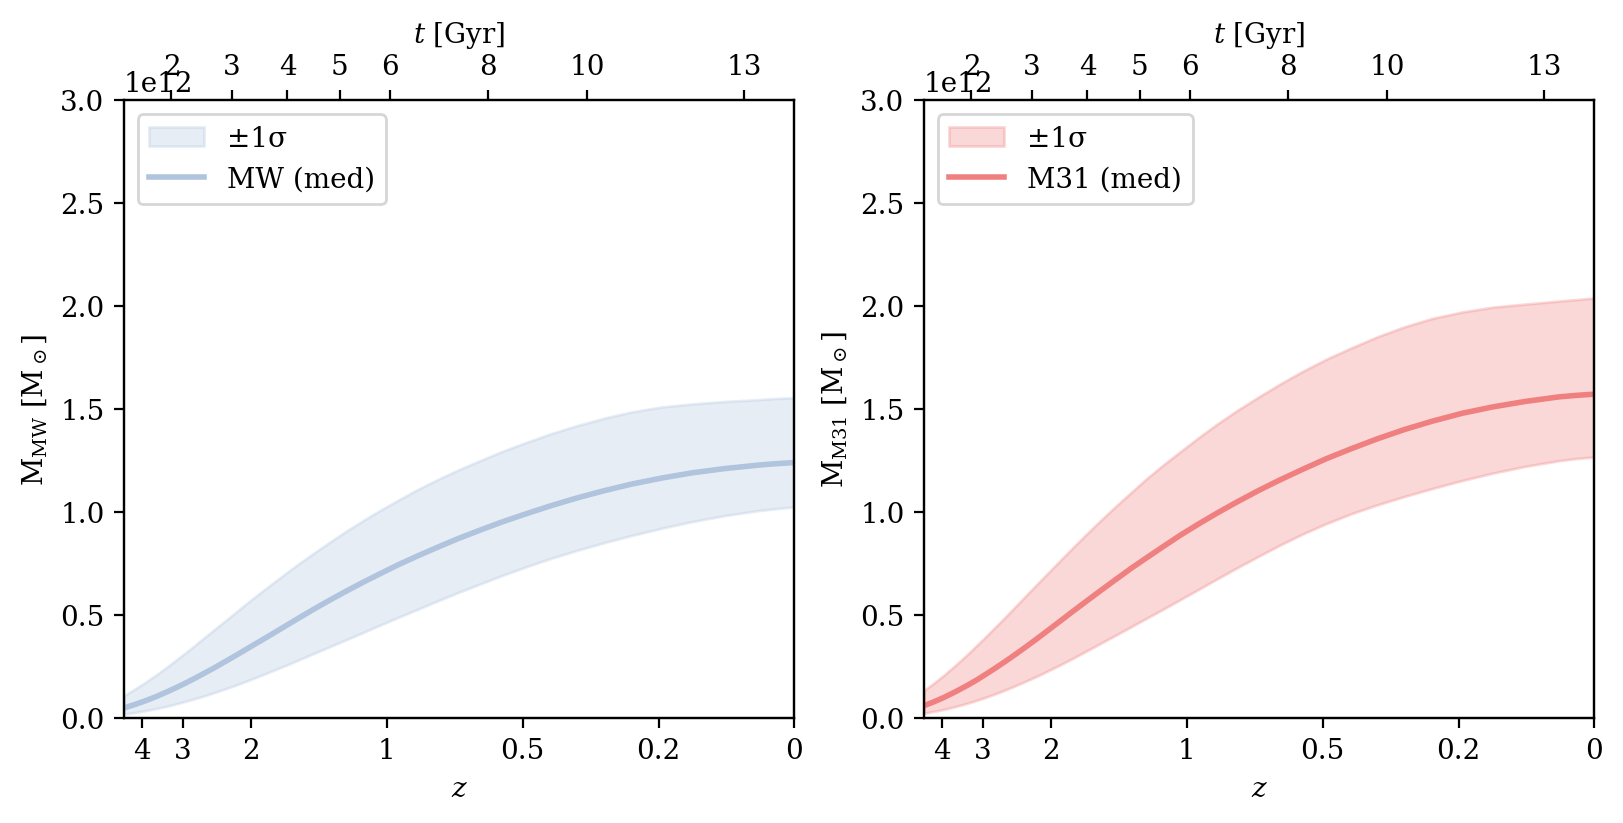

In [160]:
# Ploting

fig, axes = plt.subplots(figsize=(8,4), ncols=2, nrows=1, dpi=200, constrained_layout=True)
plot_style = {'color': 'r', 'linewidth': 0.5, 'linestyle': 'solid'}

ax_MW = axes[0]
ax_MW.fill_between(scale[fine_index], m_MW_minus1, m_MW_plus1, color='lightsteelblue', alpha=0.3, label='±1σ')
ax_MW.plot(scale[fine_index], m_MW_med, color='lightsteelblue', lw=2, label='MW (med)')
ax_MW.legend(loc='upper left')

ax_M31 = axes[1]
ax_M31.fill_between(scale[fine_index], m_M31_minus1, m_M31_plus1, color='lightcoral', alpha=0.3, label='±1σ')
ax_M31.plot(scale[fine_index], m_M31_med, color='lightcoral', lw=2, label='M31 (med)')
ax_M31.legend(loc='upper left')

# Axes

for ax in axes:

    ax.set_xticks(label_scales)
    ax.set_xticklabels(label_redshifts_str)
    ax.set_xlabel(r'$z$')

    ax2 = ax.twiny()
    ax2.set_xlabel(r'$t\ \mathrm{[Gyr]}$')
    ax2.set_xticks(ageticks)
    ax2.set_xticklabels(['{:g}'.format(age) for age in ages.value])

    ax.set_xlim(min(scale[fine_index]), 1)
    ax.set_ylim(0, 3e12)
    ax2.set_xlim(min(scale[fine_index]), 1)
    ax2.set_ylim(0, 3e12)

axes[0].set_ylabel(r'$\mathrm{M_{MW} \ [M_\odot]}$')
axes[1].set_ylabel(r'$\mathrm{M_{M31} \ [M_\odot]}$')

# Save plot
plt.savefig('MW_M31_NO_LG_2_plots_evolution_mass.png')
plt.show()

### Same plot normalised

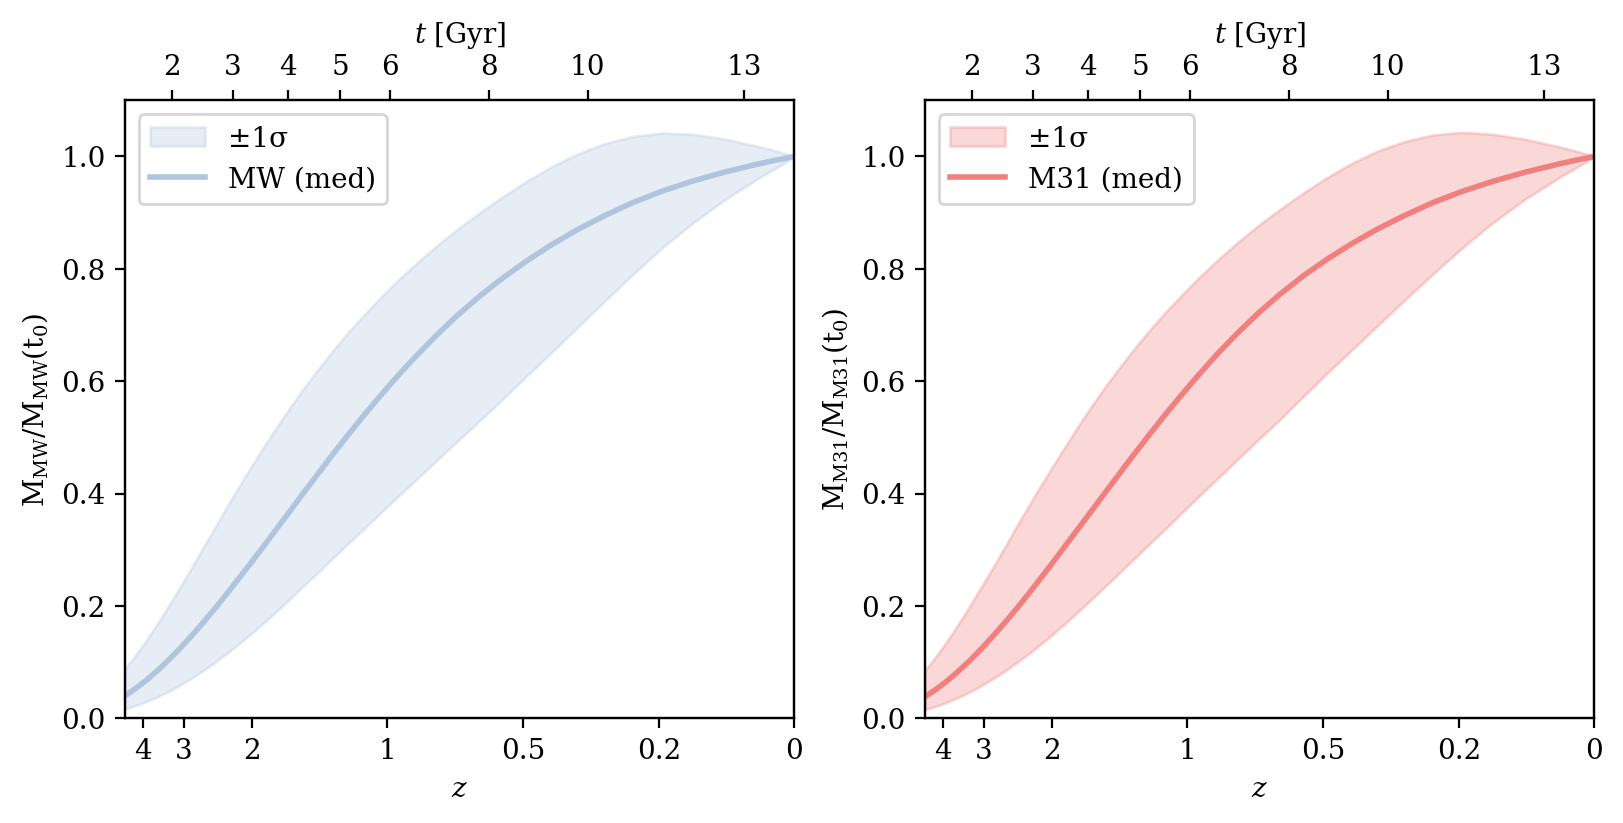

In [161]:
# Ploting

fig, axes = plt.subplots(figsize=(8,4), ncols=2, nrows=1, dpi=200, constrained_layout=True)
plot_style = {'color': 'r', 'linewidth': 0.5, 'linestyle': 'solid'}

ax_MW = axes[0]
ax_MW.fill_between(scale[fine_index], m_MW_minus1_norm, m_MW_plus1_norm, color='lightsteelblue', alpha=0.3, label='±1σ')
ax_MW.plot(scale[fine_index], m_MW_med_norm, color='lightsteelblue', lw=2, label='MW (med)')
ax_MW.legend(loc='upper left')

ax_M31 = axes[1]
ax_M31.fill_between(scale[fine_index], m_M31_minus1_norm, m_M31_plus1_norm, color='lightcoral', alpha=0.3, label='±1σ')
ax_M31.plot(scale[fine_index], m_M31_med_norm, color='lightcoral', lw=2, label='M31 (med)')
ax_M31.legend(loc='upper left')

# Axes

for ax in axes:

    ax.set_xticks(label_scales)
    ax.set_xticklabels(label_redshifts_str)
    ax.set_xlabel(r'$z$')

    ax2 = ax.twiny()
    ax2.set_xlabel(r'$t\ \mathrm{[Gyr]}$')
    ax2.set_xticks(ageticks)
    ax2.set_xticklabels(['{:g}'.format(age) for age in ages.value])

    ax.set_xlim(min(scale[fine_index]), 1)
    ax.set_ylim(0, 1.1)
    ax2.set_xlim(min(scale[fine_index]), 1)
    ax2.set_ylim(0, 1.1)

axes[0].set_ylabel(r'$\mathrm{M_{MW}/M_{MW}(t_0)}$')
axes[1].set_ylabel(r'$\mathrm{M_{M31}/M_{M31}(t_0)}$')



# Save plot
plt.savefig('MW_M31_NO_LG_2_plots_normalised_evolution_mass.png')
plt.show()

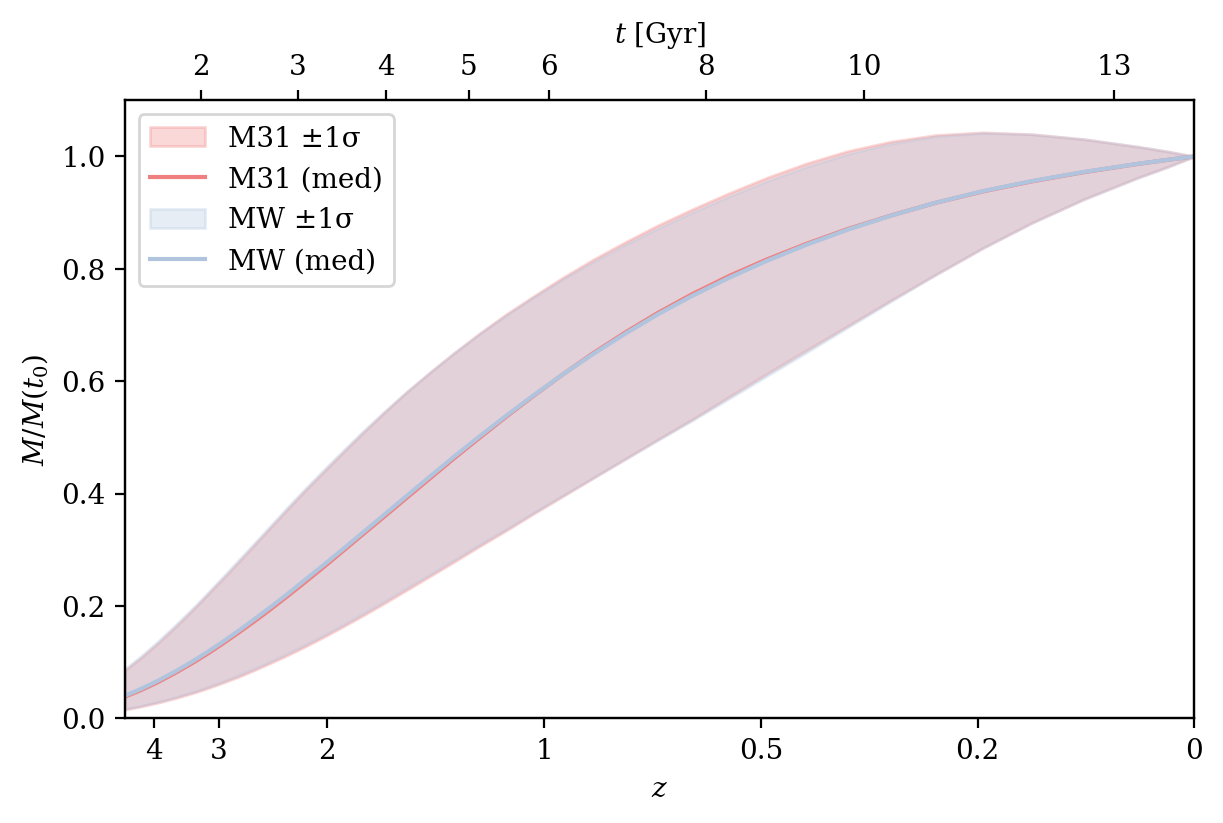

In [162]:
#------------
# Ploting
#------------

fig, ax = plt.subplots(figsize=(6,4), dpi=200, constrained_layout=True)

ax.fill_between(scale[fine_index],
                m_M31_minus1_norm, m_M31_plus1_norm,
                color='lightcoral', alpha=0.3,
                label='M31 ±1σ')
ax.plot(scale[fine_index],
        m_M31_med_norm,
        color='lightcoral', lw=1.5,
        label='M31 (med)')

ax.fill_between(scale[fine_index],
                m_MW_minus1_norm, m_MW_plus1_norm,
                color='lightsteelblue', alpha=0.3,
                label='MW ±1σ')
ax.plot(scale[fine_index],
        m_MW_med_norm,
        color='lightsteelblue', lw=1.5,
        label='MW (med)')

#------------
# Axes
#------------

# Redshift
ax.set_xticks(label_scales)
ax.set_xticklabels(label_redshifts_str)
ax.set_xlabel(r'$z$')
ax.set_xlim(min(scale[fine_index]), 1)

# Time in Gyr
ax2 = ax.twiny()
ax2.set_xlabel(r'$t\ \mathrm{[Gyr]}$')
ax2.set_xticks(ageticks)
ax2.set_xticklabels([f'{age:g}' for age in ages.value])
ax2.set_xlim(min(scale[fine_index]), 1)

# Normalised mass
ax.set_ylim(0, 1.1)
ax.set_ylabel(r'$M/M(t_0)$')

# Legend
ax.legend(loc='upper left')

# ---------------
# Save and show
# ---------------
plt.savefig('MW_M31_NO_LG_superposed_normalised_evolution_mass.png')
plt.show()


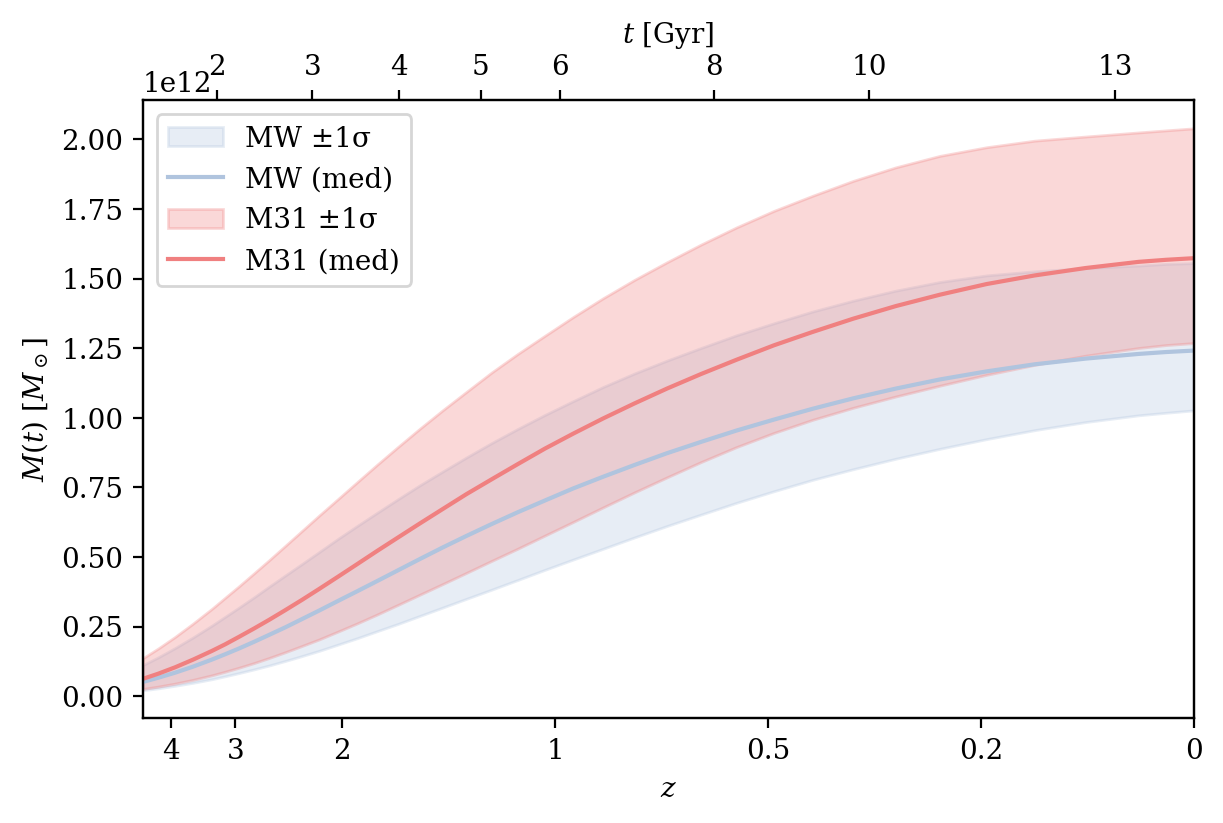

In [163]:
fig, ax = plt.subplots(figsize=(6,4), dpi=200, constrained_layout=True)

# Tracé pour MW
ax.fill_between(scale[fine_index],
                m_MW_minus1, m_MW_plus1,
                color='lightsteelblue', alpha=0.3,
                label='MW ±1σ')
ax.plot(scale[fine_index],
        m_MW_med,
        color='lightsteelblue', lw=1.5,
        label='MW (med)')

# Tracé pour M31
ax.fill_between(scale[fine_index],
                m_M31_minus1, m_M31_plus1,
                color='lightcoral', alpha=0.3,
                label='M31 ±1σ')
ax.plot(scale[fine_index],
        m_M31_med,
        color='lightcoral', lw=1.5,
        label='M31 (med)')

ax.set_xticks(label_scales)
ax.set_xticklabels(label_redshifts_str)
ax.set_xlabel(r'$z$')
ax.set_xlim(min(scale[fine_index]), 1)

ax.set_ylabel(r'$M(t)\ [M_\odot]$')

ax2 = ax.twiny()
ax2.set_xlabel(r'$t\ \mathrm{[Gyr]}$')
ax2.set_xticks(ageticks)
ax2.set_xticklabels([f'{age:g}' for age in ages.value])
ax2.set_xlim(min(scale[fine_index]), 1)


ax.legend(loc='upper left')
plt.savefig('MW_M31_NO_LG_superposed_evolution_mass.png')
plt.show()
